In [159]:
import configparser
import psycopg2
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix,auc,accuracy_score,classification_report, roc_auc_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import ttest_ind

In [160]:
config = configparser.ConfigParser()
config.read('C:\Files and Folders\project\dwh.cfg')

['C:\\Files and Folders\\project\\dwh.cfg']

In [161]:
conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
cur = conn.cursor()

In [162]:
query = 'SELECT * FROM trainingChurn'
df = pd.read_sql(query, conn)
cur.close()
conn.close()
df.head()

user_id  nb_visits  nb_purchase  amount_purchase  nb_products_seen  \
0    89885        515            0              0.0               400   
1   150086         18            0              0.0                13   
2   125617         54            1              6.0                32   
3    58628       1325            4            116.0               377   
4    70649        384            1             11.0               296   

   nb__distinct_products  nb_distinct_category0  nb_distinct_category1  \
0                    322                     10                     74   
1                     13                      7                     11   
2                     28                      7                     17   
3                    328                     11                     66   
4                    293                     11                     62   

   nb_distinct_category2  nb_distinct_product_purchased  ...  \
0                     74                              0  ...   
1                     11                              0  ...   
2                     17                              1  ...   
3                     66                              4  ...   
4                     63                              1  ...   

   nb_associated_months  nb_days_last_activity  nb_days_last_purchase  \
0                     6                      1                  99999   
1                     6                     22                  99999   
2                     6                     18                     20   
3                     6                      1                      9   
4                     6                      1                     12   

   nb_active_months  nb_active_purchase_months  nb_purchase_total  \
0                 7                          0                  0   
1                 7                          0                  0   
2                 7                          1                  1   
3                 7                          3                  4   
4                 7                          3                  4   

   amount_purchase_total  no_activity_evaluation_period  \
0                    0.0                              0   
1                    0.0                              0   
2                    6.0                              0   
3                  116.0                              0   
4                  404.0                              0   

   amount_purchase_evaluation_period  no_purchase_evaluation_period  
0                                  1                              0  
1                                  0                              1  
2                                  0                              1  
3                                  3                              0  
4                                  4                              0  

[5 rows x 31 columns]

In [163]:
# df = pd.read_csv(r'final_dataset.csv').sample(frac=1, random_state=42)
# df.head()

In [164]:
df.describe()

user_id     nb_visits   nb_purchase  amount_purchase  \
count   44350.000000  44350.000000  44350.000000     4.435000e+04   
mean    75738.324938     15.007666      0.498579     2.122256e+03   
std     43798.511367     65.823675      1.880901     2.795281e+05   
min         1.000000      1.000000      0.000000     0.000000e+00   
25%     37666.250000      1.000000      0.000000     0.000000e+00   
50%     75606.500000      3.000000      0.000000     0.000000e+00   
75%    113685.750000      9.000000      1.000000     3.000000e+00   
max    151848.000000   5966.000000    106.000000     4.109308e+07   

       nb_products_seen  nb__distinct_products  nb_distinct_category0  \
count      44350.000000           44350.000000           44350.000000   
mean          10.524983               9.590147               2.788140   
std           53.562410              38.670383               2.595548   
min            0.000000               0.000000               0.000000   
25%            1.000000               1.000000               1.000000   
50%            2.000000               2.000000               2.000000   
75%            7.000000               6.000000               4.000000   
max         5703.000000            3006.000000              11.000000   

       nb_distinct_category1  nb_distinct_category2  \
count           44350.000000           44350.000000   
mean                5.288005               5.302120   
std                 8.616186               8.675896   
min                 0.000000               0.000000   
25%                 1.000000               1.000000   
50%                 2.000000               2.000000   
75%                 6.000000               6.000000   
max               107.000000             114.000000   

       nb_distinct_product_purchased  ...  nb_associated_months  \
count                   44350.000000  ...          44350.000000   
mean                        0.496032  ...              1.701037   
std                         1.873847  ...              2.196584   
min                         0.000000  ...              0.000000   
25%                         0.000000  ...              0.000000   
50%                         0.000000  ...              0.000000   
75%                         1.000000  ...              3.000000   
max                       106.000000  ...              6.000000   

       nb_days_last_activity  nb_days_last_purchase  nb_active_months  \
count           44350.000000           44350.000000      44350.000000   
mean               48.005096           70003.851432          2.301533   
std                36.752176           45801.657735          1.826400   
min                 1.000000               1.000000          1.000000   
25%                15.000000             114.000000          1.000000   
50%                39.000000           99999.000000          1.000000   
75%                81.000000           99999.000000          3.000000   
max               122.000000           99999.000000          7.000000   

       nb_active_purchase_months  nb_purchase_total  amount_purchase_total  \
count               44350.000000       44350.000000           4.435000e+04   
mean                    0.389267           0.654431           2.149549e+03   
std                     0.733760           2.502292           2.795682e+05   
min                     0.000000           0.000000           0.000000e+00   
25%                     0.000000           0.000000           0.000000e+00   
50%                     0.000000           0.000000           0.000000e+00   
75%                     1.000000           1.000000           7.000000e+00   
max                     7.000000         143.000000           4.109308e+07   

       no_activity_evaluation_period  amount_purchase_evaluation_period  \
count                   44350.000000                       44350.000000   
mean                        0.635738                           0.167306   
std                         0.481228           

## Exploratory Data Analysis
Missing data check

In [123]:
df.isnull().sum()

user_id                                      0
nb_visits                                    0
nb_purchase                                  0
amount_purchase                              0
nb_products_seen                             0
nb__distinct_products                        0
nb_distinct_category0                        0
nb_distinct_category1                        0
nb_distinct_category2                        0
nb_distinct_product_purchased                0
nb_distinct_category_purchased               0
nb_visits_last_month                         0
nb_purchase_last_month                       0
amount_purchase_last_month                   0
nb_products_seen_last_month                  0
nb__distinct_products_last_month             0
nb_distinct_category0_last_month             0
nb_distinct_category1_last_month             0
nb_distinct_category2_last_month             0
nb_distinct_product_purchased_last_month     0
nb_distinct_category_purchased_last_month    0
nb_associated

Checking for Class Imbalance

Text(0.5, 1.0, 'Number of Users Churned')

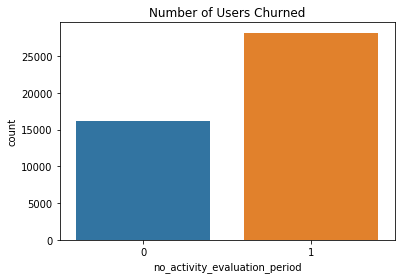

In [124]:
sns.countplot(x='no_activity_evaluation_period', data=df).set_title('Number of Users Churned')

Correlation and scatter Plot

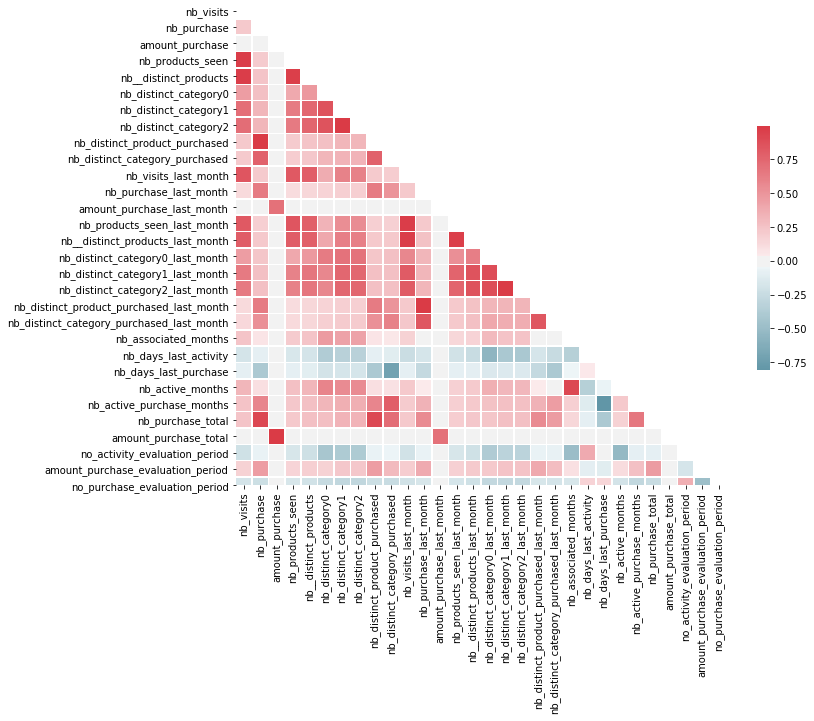

In [125]:
corr = df.loc[:, df.columns != 'user_id'].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
#corr

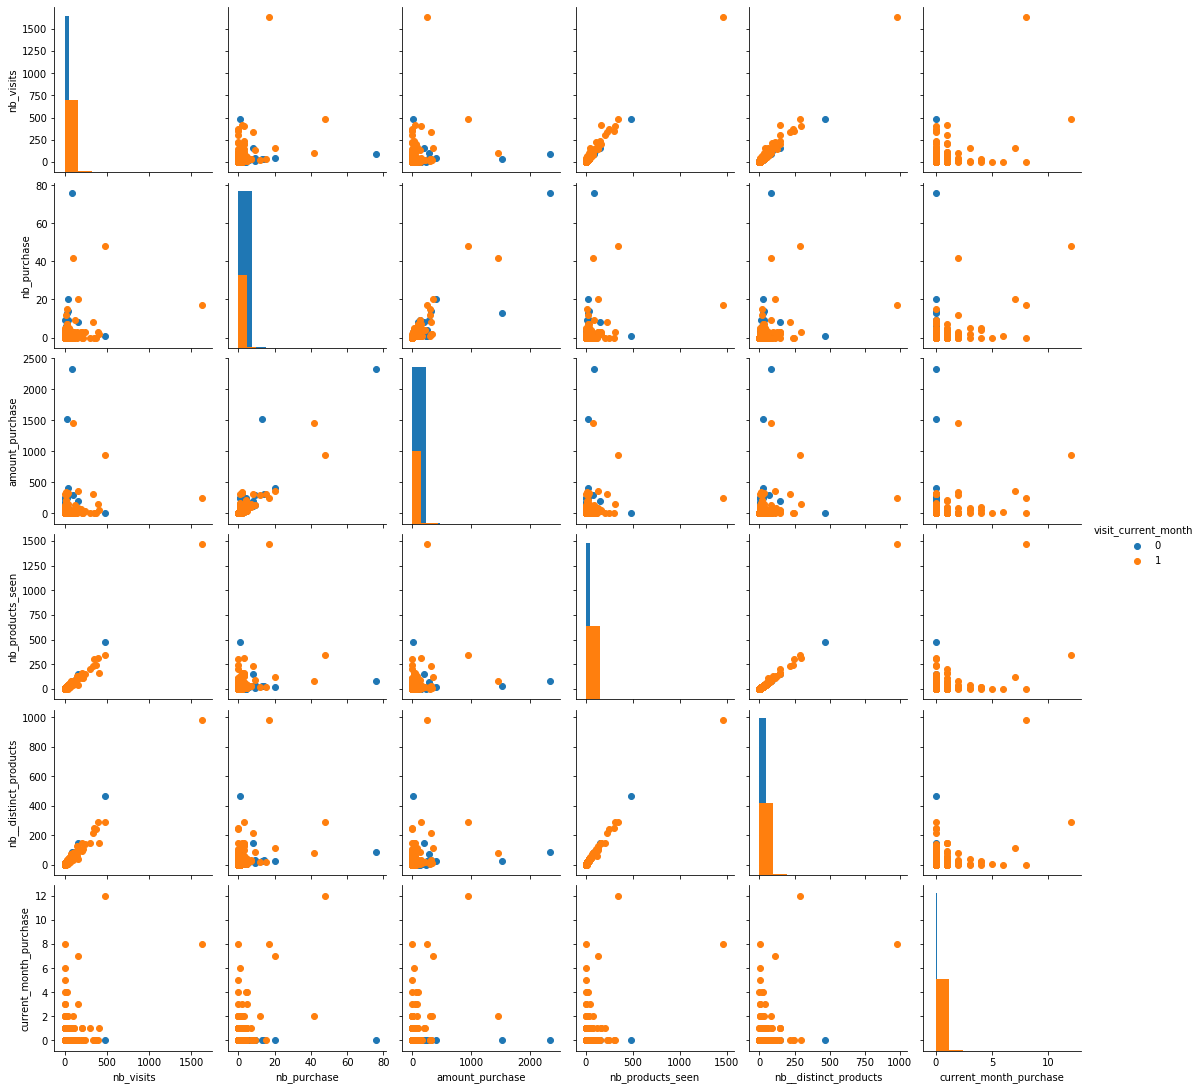

In [53]:
df_sample = pd.concat([df.iloc[:,1:6],df.iloc[:,-3:-1]], axis=1).sample(frac=0.05)
g = sns.PairGrid(df_sample, hue="visit_current_month")
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
g = g.add_legend()

Spliting Data into Test and Train Dataset

In [165]:
X = df.loc[:,~df.columns.isin(['user_id', 'no_activity_evaluation_period','amount_purchase_evaluation_period','no_purchase_evaluation_period'])]
y = df.loc[:, 'no_activity_evaluation_period']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#X_train['Y'] = y_train
#X_train = X_train.sample(frac=0.10, random_state=42)
#y_train = X_train['Y']
#X_train = X_train.drop('Y', axis=1)

X_train.head()

nb_visits  nb_purchase  amount_purchase  nb_products_seen  \
20279         34            0              0.0                25   
1889           4            1             13.0                 4   
25366          5            0              0.0                 5   
24802          1            0              0.0                 0   
12350         19            5             79.0                17   

       nb__distinct_products  nb_distinct_category0  nb_distinct_category1  \
20279                     24                      5                     15   
1889                       4                      3                      4   
25366                      5                      2                      3   
24802                      0                      0                      0   
12350                     16                      9                     15   

       nb_distinct_category2  nb_distinct_product_purchased  \
20279                     16                              0   
1889                       4                              1   
25366                      3                              0   
24802                      0                              0   
12350                     15                              5   

       nb_distinct_category_purchased  ...  nb_distinct_category2_last_month  \
20279                               0  ...                                 6   
1889                                1  ...                                 0   
25366                               0  ...                                 0   
24802                               0  ...                                 0   
12350                               4  ...                                 0   

       nb_distinct_product_purchased_last_month  \
20279                                         0   
1889                                          0   
25366                                         0   
24802                                         0   
12350                                         0   

       nb_distinct_category_purchased_last_month  nb_associated_months  \
20279                                          0                     2   
1889                                           0                     3   
25366                                          0                     0   
24802                                          0                     0   
12350                                          0                     1   

       nb_days_last_activity  nb_days_last_purchase  nb_active_months  \
20279                     12                  99999                 3   
1889                     115                    115                 3   
25366                     36                  99999                 1   
24802                     47                  99999                 1   
12350                    101                    104                 2   

       nb_active_purchase_months  nb_purchase_total  amount_purchase_total  
20279                          0                  0                    0.0  
1889                           1                  1                   13.0  
25366                          0                  0                    0.0  
24802                          0                  0                    0.0  
12350                          1                  5                   79.0  

[5 rows x 27 columns]

In [166]:
def ttest(X, y, equal_var=True):
    result = []
    for col in X.columns:
        tvalue,pvalue = ttest_ind(X[col],y, equal_var=equal_var)
        result.append((col, y.name, float(tvalue), float(pvalue)))
    return pd.DataFrame(result, columns = ['Var1', 'Var2', 'tvalue', 'pvalue'])

T- test to check statistical significance

In [169]:
t_df = ttest(X, y, equal_var=False)
t_df[t_df['pvalue'] >= 0.05]

Var1                           Var2    tvalue  \
2              amount_purchase  no_activity_evaluation_period  1.598413   
12  amount_purchase_last_month  no_activity_evaluation_period  1.004236   
25           nb_purchase_total  no_activity_evaluation_period  1.544840   
26       amount_purchase_total  no_activity_evaluation_period  1.618743   

      pvalue  
2   0.109958  
12  0.315270  
25  0.122392  
26  0.105510

In [170]:
ttest_ind(np.log(X['amount_purchase_total']+1), y, equal_var=True)

Ttest_indResult(statistic=41.69786689856251, pvalue=0.0)

Text(0, 0.5, 'log(nb_vists)')

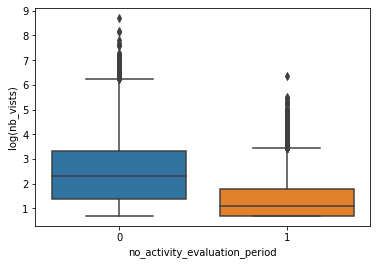

In [171]:
sns.boxplot(y=np.log(df['nb_visits']+1),x= 'no_activity_evaluation_period', data=df).set_ylabel('log(nb_vists)')

## Modeling

In [173]:
#Random Forest Model
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)
pd.DataFrame(zip(X_train.columns,rf_model.feature_importances_), columns = ['Features','Importance']).sort_values('Importance', ascending=False)

Features  Importance
21                      nb_days_last_activity    0.229553
0                                   nb_visits    0.140786
20                       nb_associated_months    0.109451
23                           nb_active_months    0.102106
10                       nb_visits_last_month    0.055551
3                            nb_products_seen    0.053026
6                       nb_distinct_category1    0.038970
4                       nb__distinct_products    0.032551
22                      nb_days_last_purchase    0.030788
5                       nb_distinct_category0    0.030086
26                      amount_purchase_total    0.024335
7                       nb_distinct_category2    0.021614
2                             amount_purchase    0.019309
16           nb_distinct_category1_last_month    0.018893
14           nb__distinct_products_last_month    0.017817
13                nb_products_seen_last_month    0.012949
15           nb_distinct_category0_last_month    0.012603
17           nb_distinct_category2_last_month    0.010886
25                          nb_purchase_total    0.007868
12                 amount_purchase_last_month    0.007214
24                  nb_active_purchase_months    0.004967
9              nb_distinct_category_purchased    0.004964
8               nb_distinct_product_purchased    0.004895
1                                 nb_purchase    0.003725
11                     nb_purchase_last_month    0.001766
19  nb_distinct_category_purchased_last_month    0.001700
18   nb_distinct_product_purchased_last_month    0.001627

In [174]:
y_pred = rf_model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred),roc_auc_score(y_test,y_pred), recall_score(y_test,y_pred), precision_score(y_test,y_pred))

[[2171 1145]
 [ 979 4575]]
0.7605411499436302 0.7392175538945839 0.8237306445804825 0.7998251748251748


In [175]:
# Logistic Regression Model
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred),roc_auc_score(y_test,y_pred), recall_score(y_test,y_pred), precision_score(y_test,y_pred))

[[1026 2290]
 [ 170 5384]]
0.7226606538895152 0.6394001780088292 0.9693914296002881 0.7015897836851707


In [176]:
# Adaboost model and Grid search method for hyperparameter tuning
Adaboost_model = AdaBoostClassifier(random_state=42)
param={'n_estimators':[10, 25 ,50, 100], 'learning_rate':[1,0.9,0.8,0.7]}
clf = GridSearchCV(Adaboost_model, cv=5,param_grid=param, n_jobs=-1, scoring ='recall')
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=42),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [1, 0.9, 0.8, 0.7],
                         'n_estimators': [10, 25, 50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [177]:
clf.cv_results_
clf.best_params_

{'learning_rate': 0.9, 'n_estimators': 10}

In [178]:
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred),roc_auc_score(y_test,y_pred), recall_score(y_test,y_pred), precision_score(y_test,y_pred))

[[1908 1408]
 [ 501 5053]]
0.7847801578354002 0.7425933905643157 0.9097947425279078 0.7820770778517258


In [179]:
# XgBoost Classifier
xgboost_model = xgb.XGBClassifier()
param = {'max_depth':[1,3,5,9],'learning_rate':[0.1,0.3,0.5],'colsample_bytree':[0.8],'n_estimators':[100,200, 500,1000]}
clf = GridSearchCV(xgboost_model, cv=5,param_grid=param, n_jobs=-1, scoring ='recall')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

KeyboardInterrupt: 

In [33]:
print(accuracy_score(y_test,y_pred))

0.7882399682161303


In [138]:
df.to_csv(r'final_dataset.csv', header =True, index=False)

In [183]:
#xgBoost Model
param ={'max_depth':9,'learning_rate':0.5,'colsample_bytree':0.8,'n_estimators':500}
xgboost_model = xgb.XGBClassifier()
xgboost_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [184]:
y_pred = xgboost_model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred),roc_auc_score(y_test,y_pred), recall_score(y_test,y_pred), precision_score(y_test,y_pred))

[[2078 1238]
 [ 573 4981]]
0.7958286358511838 0.7617448687803876 0.8968311127115592 0.8009326258240874


In [185]:
#df.to_csv(r'final_dataset.csv', header =True, index=False)